# AAut lab question 1 part 2
## The ARX model

# Initial Steps

Import Libraries

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Load the data

In [223]:
u_train = np.load('u_train.npy')
u_test = np.load('u_test.npy')
output_train = np.load('output_train.npy')

Time variables

In [224]:
N = len(u_train)
time = np.arange(0, 2550, 1)

### Create important functions

Function to calculate SSE

In [225]:
def calculate_SSE(MSE, N):
  # Calculate the sum of squared errors
  SSE = MSE * N 
  return SSE

Create the training matrix

In [226]:
def create_regressor_matrix(n, m, d, N, output, u):   
    # Create X matrix
    X = []
    Y = []
    for k in range(max(n, d + m), N):
        # Construct the regressor vector ϕ(k)
        y_part = [-output[k-i] for i in range(1, n+1)]  # past y values
        u_part = [u[k-d-i] for i in range(m+1)]  # past u values
        X.append(y_part + u_part)
        Y.append(output[k])

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Validation of the performance of the model

In [227]:
def validate_model(model, X, Y):
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    cv_results = cross_validate(model, X, Y, cv=7, scoring={'mse': mse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
    train_mse = -cv_results['train_mse'].mean()
    test_mse = -cv_results['test_mse'].mean()
    train_r2 = cv_results['train_r2'].mean()
    test_r2 = cv_results['test_r2'].mean()
    return train_mse, test_mse, train_r2, test_r2

Test best n, m, d

In [228]:
def find_best_parameters(max_params, output_train, u_train):
    best_params = {'n': None, 'm': None, 'd': None}
    best_error = float('inf')
    best_results = None

    for n in range(1, max_params + 1):
        for m in range(1, max_params + 1):
            for d in range(1, max_params + 1):
                X, Y = create_regressor_matrix(n, m, d, len(output_train), output_train, u_train)
                train_mse, test_mse, train_r2, test_r2 = validate_model(LinearRegression(), X, Y)
                model = LinearRegression().fit(X, Y)
                poles = np.roots(np.insert(model.coef_[0:n], 0, 1))
                if np.all(np.abs(poles) < 1):
                    if test_mse < best_error:
                        best_error = test_mse
                        best_params = {'n': n, 'm': m, 'd': d}
                        best_results = (train_mse, test_mse, train_r2, test_r2)

    return best_params, best_results

## Test best parameters

In [229]:
# Find the best parameters
max_params = 9
best_params, best_results = find_best_parameters(max_params, output_train, u_train)

print(f"Best Parameters: n={best_params['n']}, m={best_params['m']}, d={best_params['d']}")
print(f"Train MSE: {best_results[0]}")
print(f"Test MSE: {best_results[1]}")
print(f"Train R2: {best_results[2]}")
print(f"Test R2: {best_results[3]}")

Best Parameters: n=9, m=9, d=6
Train MSE: 0.014748779236049487
Test MSE: 0.015011113971460198
Train R2: 0.9996591705042371
Test R2: 0.9996055612722842


## Test best model
Use best parameters from before

In [230]:
n = 9  # order for y (output)
m = 9  # order for u (input)
d = 6  # delay

In [231]:
X, Y = create_regressor_matrix(n, m, d, N, output_train, u_train)

In [232]:
train_mse_LR, test_mse_LR, train_r2_LR, test_r2_LR = validate_model(LinearRegression(), X, Y)

train_mse_L, test_mse_L, train_r2_L, test_r2_L = validate_model(LassoCV(max_iter=10000),X, Y)

train_mse_R, test_mse_R, train_r2_R, test_r2_R = validate_model(RidgeCV(), X, Y)

# Combine all MSE and R2 results
results = {
    'LinearRegression': (train_mse_LR, test_mse_LR, train_r2_LR, test_r2_LR),
    'LassoCV': (train_mse_L, test_mse_L, train_r2_L, test_r2_L),
    'RidgeCV': (train_mse_R, test_mse_R, train_r2_R, test_r2_R),
}

# Find the best model based on test MSE
best_model = min(results, key=lambda k: results[k][1])
best_train_mse, best_test_mse, best_train_r2, best_test_r2 = results[best_model]

print(f"Best Model: {best_model}")
print(f"Train SSE: {calculate_SSE(best_train_mse, len(Y))}")
print(f"Test SSE: {calculate_SSE(best_test_mse, len(Y))}")
print(f"Train R2: {best_train_r2}")
print(f"Test R2: {best_test_r2}")

Best Model: RidgeCV
Train SSE: 29.87058594795947
Test SSE: 30.396534486134748
Train R2: 0.999659121298304
Test R2: 0.9996054707884557


## Final output prediction

In [233]:
# Fit the ARX model using linear regression
model = LinearRegression() # Change to the best model from before
model.fit(X, Y)

LinearRegression()

In [234]:
# Now make predictions on the test set (u_test)
predicted_y_test = []
y_prev = list(output_train[-n:])  # Initialize with the last n values of y from training set

for k in range(len(u_test)):
    # Create the regressor for the test set
    y_part = [-y_prev[i] for i in range(n)]  # Use predicted y values iteratively
    u_part = [u_test[k-d-i] if k-d-i >= 0 else 0 for i in range(m+1)]  # Past u values from u_test
    Omega_test = np.array(y_part + u_part)
    # Predict y(k)
    y_pred = model.predict(Omega_test.reshape(1, -1))[0]
    
    # Append the prediction and update y_prev for the next iteration
    predicted_y_test.append(y_pred)
    y_prev = [y_pred] + y_prev[:-1]  # Update with the new prediction

# Convert to numpy array
predicted_y_test = np.array(predicted_y_test)

In [235]:
# Save only the last 400 samples for submission (indexes 110 to 509 of test data)
final_predictions = predicted_y_test[-400:]
np.save('predicted_y_test.npy', final_predictions)

Text(0, 0.5, 'Output')

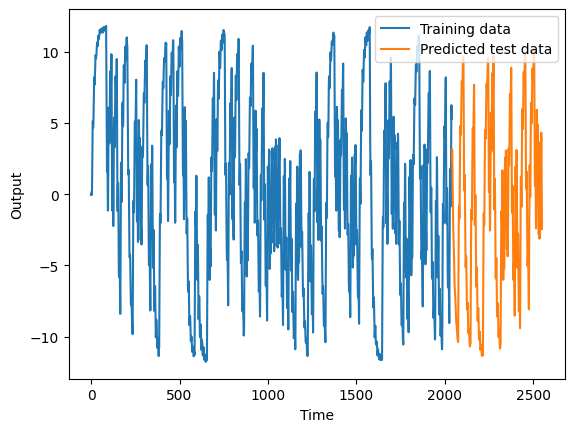

In [236]:
plt.plot(time[:N], output_train)
plt.plot(time[-510:], predicted_y_test)
plt.legend(['Training data', 'Predicted test data'])
plt.xlabel('Time')
plt.ylabel('Output')